# Unsupervised Anomaly Detction Technique 2

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The time and amount are the two columns which are not transformed with pca. now i will transform the two for better accuracy if any

In [3]:
from sklearn.decomposition import PCA
cols= df[['Time', 'Amount']]

pca_reduction = PCA()
pca_reduction.fit(cols)
X_PCA = pca_reduction.transform(cols)

df['V29']=X_PCA[:,0]
df['V30']=X_PCA[:,1]

df.drop(['Time', 'Amount'], axis=1, inplace=True)

df.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class', 'V29', 'V30'],
      dtype='object')

Now, let me use ztest feature selection by performing ztest and select the most significant features
Z score = observed value - mean of the sample / the std deviation of the sample
This is a two tailed ztest with 2.58 as critival value

In [4]:
state= 42

In [5]:
def ztest_on_features(variables):
    
    mean = normal[variables].mean()
    std = fraud[variables].std()
    ZScore = (fraud[variables].mean() - mean) / (std/np.sqrt(sample_size))
    
    return ZScore

In [6]:
columns= df.drop('Class', axis=1).columns
normal= df[df.Class==0]
fraud= df[df.Class==1]
sample_size=len(fraud)
valid_features=[]
corr_critical_value=2.58 

for i in columns:
    
    z_vavlue=ztest_on_features(i)
    
    if( abs(z_vavlue) >= corr_critical_value):    
        print(i," valid variable")
        valid_features.append(i)

V1  valid variable
V2  valid variable
V3  valid variable
V4  valid variable
V5  valid variable
V6  valid variable
V7  valid variable
V9  valid variable
V10  valid variable
V11  valid variable
V12  valid variable
V14  valid variable
V16  valid variable
V17  valid variable
V18  valid variable
V19  valid variable
V20  valid variable
V21  valid variable
V24  valid variable
V27  valid variable
V28  valid variable
V29  valid variable
V30  valid variable


The v13,v15,v22,v23,v25,v26 features are not significant and will now exclude it from the datset

In [7]:
valid_features.append('Class')
df= df[valid_features]

normal_features = df[df.Class==0]
inputs = normal_features.drop(['Class'], axis=1)

anomaly_features = df[df.Class==1]
outputs = anomaly_features.drop(['Class'], axis=1)

inputs.shape, outputs.shape

((284315, 23), (492, 23))

In [8]:
def normal_accuracy(value):
    tp=list(value).count(1)
    total=value.shape[0]
    accuracy=np.round(tp/total,4)
    return accuracy
def fraud_accuracy(value):
    tn=list(value).count(-1)
    total=value.shape[0]
    accuracy=np.round(tn/total,4)
    return accuracy

In [9]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(random_state=state)
iso_forest.fit(inputs)

normal_if = iso_forest.predict(inputs)
fraud_if = iso_forest.predict(outputs)

input_accuracy_if=normal_accuracy(normal_if)
output_accuracy_if=fraud_accuracy(fraud_if)
print("Accuracy Normal Cases:", input_accuracy_if)
print("Accuracy Fraud Cases:", output_accuracy_if)

C:\Users\abhim\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Accuracy Normal Cases: 0.9
Accuracy Fraud Cases: 0.9004


C:\Users\abhim\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


In [10]:
lof = LocalOutlierFactor(novelty=True)
lof.fit(inputs)

normal_lof = lof.predict(inputs)
fraud_lof = lof.predict(outputs)

input_accuracy_lof=normal_accuracy(normal_lof)
output_accuracy_lof=fraud_accuracy(fraud_lof)
print("Accuracy Normal Cases:", input_accuracy_lof)
print("Accuracy Fraud Cases:", output_accuracy_lof)

Accuracy Normal Cases: 0.9171
Accuracy Fraud Cases: 0.5142


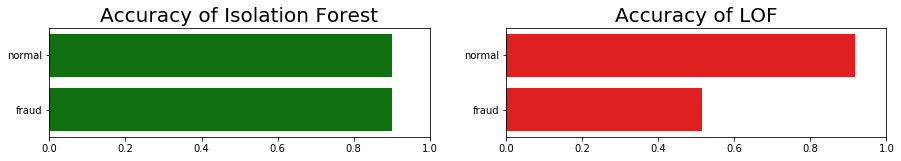

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, (ax1,ax2)= plt.subplots(1,2, figsize=[15,2])

ax1.set_title("Accuracy of Isolation Forest",fontsize=20)
sns.barplot(x=[input_accuracy_if,output_accuracy_if], 
            y=['normal', 'fraud'],
            label="classifiers", 
            color="g", 
            ax=ax1)
ax1.set(xlim=(0,1))

ax2.set_title("Accuracy of LOF",fontsize=20)
sns.barplot(x=[input_accuracy_lof,output_accuracy_lof], 
            y=['normal', 'fraud'], 
            label="classifiers", 
            color="r", 
            ax=ax2)
ax2.set(xlim=(0,1))
plt.show()

Conclusion: 
a)The IF and LOF predicted the same number of Normal transactions.
b)The Fraud Transactions are identified by IF is more accurate as compared to LOF
c) Hence, Isolation Forest is a better performer for anomaly detection as compared to LOF